# Project 1

## Exploratory data analysis and preprocessing

The **exploratory data analysis** is the statistical treatment to which the samples collected during a research process in any scientific field are subjected.
For greater speed and accuracy, the entire process is usually carried out by computer, with specific applications for statistical treatment.

### Application to Data Mining

In **data mining**, although not mandatory, it is a good practice to analyze the data you will be working with in order to observe its main characteristics and to get an idea of the structure of the dataset, identify the target variable and possible modeling techniques.

**Basic Process**
- *Transform the data*: It helps us know what to do with null, missing values or atypical data. In addition, it establishes if there is a need to reduce the dimensionality of data.
- *Visualize*: Use some tool to make a graphical representation of the data, for example, R, Jupyter notebook, Google Colab, etc.
- *Analyze and interpret*: Analyze and interpret the data through different visualizations.
- *Document*: Document all the graphs and statistics generated.

This process is also helpful when reviewing the data description to understand the meaning of each characteristic.

There are several activities in doing an exploratory data analysis but in terms of data mining the key points to be made are:
- Description of the data structure.
- Identification of missing data.
- Detection of outliers.
- Identification of relationships between variable pairs.

___

The **goal of this project** is to learn how to do data exploration. In this case, data from **New York City Yellow Taxis** is used.

At the end of the notebook, you should be able to answer the following question:


## How has covid affected the use of taxis in New York?

Some of the questions you will ask yourselves throughout the notebook are:
- How has covid changed the use of taxis in NYC?
- What pick-up distribution do the taxis follow and what distance / duration do they take?
- What are the areas where taxis are picked up the least? And where else do people go?
- What are the most usual times?
- Which days of the week and month are used the most? Possible reasons?

**Install and import the required libraries**

In [1]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes

In [2]:
# Libraries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [3]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Global variables
YEARS = [2019, 2020, 2021]

First of all, you need to download the data:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [5]:
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

___

## 01. Data cleaning

In order to have clean and useful data, it is necessary to delete all those rows that contain corrupt information:
- The pick-up is after the drop-off.
- Dates are imported by months and years. Are the dates correct?
- Traveling with zero passengers?
- Do you travel very long or particularly short?
- Negative payments.

**Data Dictionary**

Only the next columns are needed:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Remarks:**

- To speed up the calculations and reduce the computation time, do a uniform sampling of the data (a sample out of 1000).
- Datetime columns are *to_datetime* series (help to search functions)

In [6]:
def load_table(year, month):
    """
    Function that reads the downloaded data and converts it to a DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [7]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
                 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data, year, month, sampling = 1000):
    """
    Function that clears the month data.
    """
    data = data[::sampling]
    data = data[required_data]
    data = data[data.tpep_pickup_datetime < data.tpep_dropoff_datetime]
    data = data[data.passenger_count > 0]
    data = data[np.logical_not(np.isnan(data.passenger_count))]  #eliminate NANs
    data["year"] = year  #create the "year" column
    
    return data

In the ***post_processing*** function you can add all information you need in order to perform the necessary exploration.

In [8]:
def post_processing(data):
    """
    Function to implement any type of post-processing required.
    """
    data["trip_distance"] = data["trip_distance"] * 1.6  #transform miles to kms
    data["month_pickup"] = data.tpep_pickup_datetime.dt.month
    
    return data

Create a new dataset that contains all the information for the years: 2019, 2020, and 2021.

Remember that in order to reduce the memory required, you can take a subsample of the data.

In [9]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
df = post_processing(df)
df.shape

(134559, 11)

In [11]:
df.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,month_pickup
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,1
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,1
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,1
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,1
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,1
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1.0,4.336,161,262,1,13.5,17.76,2019,1
6000,2019-01-01 00:16:51,2019-01-01 00:33:46,1.0,11.360,144,82,2,22.5,23.80,2019,1
7000,2019-01-01 00:40:11,2019-01-01 00:45:02,5.0,1.792,43,237,1,6.0,8.76,2019,1
8000,2019-01-01 00:41:49,2019-01-01 00:47:09,1.0,2.112,74,263,2,6.0,7.30,2019,1
9000,2019-01-01 00:49:25,2019-01-01 01:16:02,1.0,8.576,249,262,1,21.0,26.76,2019,1


## 02. Visualizations (by years)

### Number of trips by year

Can you answer the question: **Has covid increased / decreased the number of trips made by taxis?**

To answer this question, create a bar figure showing the number of trips per year.

In [12]:
np.unique(df["year"], return_counts = True)

(array([2019, 2020, 2021], dtype=int64),
 array([82536, 23333, 28690], dtype=int64))

In [13]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    A function that creates a bar figure from the dataframe *df* and the content of the *column* that contains the information.
    """
    plt.bar(*np.unique(df[column], return_counts = True))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.xticks(YEARS)

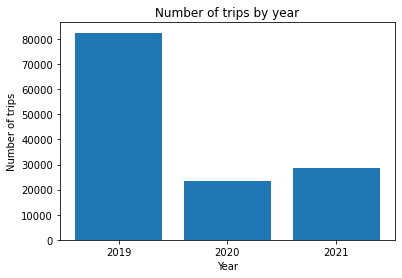

In [14]:
bar_plot(df, 'year', 'Year', 'Number of trips', 'Number of trips by year')

**Question: Is this the behavior you expected? Why?**

> Yes. The COVID 19 made people stay at home and drastically reduced the amount of taxi rides in 2020. In 2021 we can already see in the graph a slight resumption of people's movement in the city.

___

Now, you will visualize **how many passengers there are per taxi and per year**.

Create a figure with three subplots (one per year) where can be seen the number of passengers per year.

Then repeat the same chart viewing the % (use the *norm* parameter).

In [15]:
df[df["year"]==2019][['passenger_count']].value_counts(normalize=False).reset_index()

,passenger_count,0
0,1.0,58990
1,2.0,12708
2,3.0,3587
3,5.0,3414
4,6.0,2126
5,4.0,1711


In [16]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Function that displays how many passengers there are per taxi and per year
    """
    fig, axs = plt.subplots(3, 1, figsize = (6, 6))
    
    df2 = df[df["year"]==2019][['passenger_count']].value_counts(normalize=norm).reset_index()
    axs[0].bar(x=df2["passenger_count"], height=df2[0])
    axs[0].set_title(title)
    axs[0].set_ylim(ylim)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel + " 2019")
    
    df2 = df[df["year"]==2020][['passenger_count']].value_counts(normalize=norm).reset_index()
    axs[1].bar(x=df2["passenger_count"], height=df2[0])
    axs[1].set_ylim(ylim)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel + " 2020")
    
    df2 = df[df["year"]==2021][['passenger_count']].value_counts(normalize=norm).reset_index()
    axs[2].bar(x=df2["passenger_count"], height=df2[0])
    axs[2].set_ylim(ylim)
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylabel(ylabel + " 2021")
    

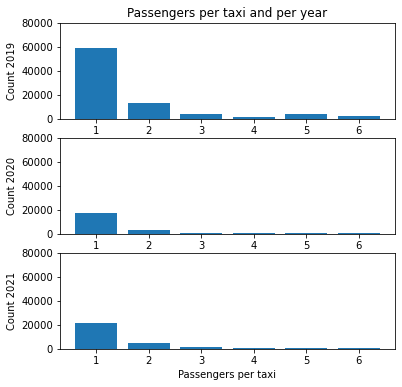

In [17]:
passengers_taxi_year(df, (0, 80000), 'Passengers per taxi', 'Count', 'Passengers per taxi and per year')

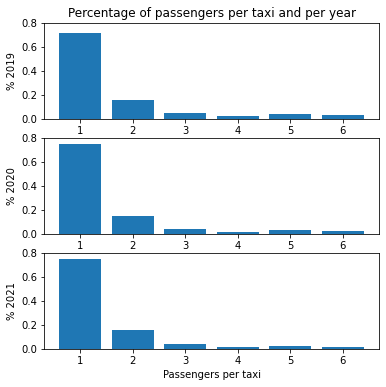

In [18]:
passengers_taxi_year(df, (0, 0.8), 'Passengers per taxi', '%', 'Percentage of passengers per taxi and per year', norm = True)

___

In the previous figure, you have visualized each year separately. To make the visualization easier to interpret, combine all the information into a graph.

The expected visualization has to contain three columns (different colors) for each number of passengers.

Then repeat the same chart viewing the % (use the *norm* parameter).

In [19]:
df[["year", "passenger_count"]].value_counts().reset_index()

,year,passenger_count,0
0,2019,1.0,58990
1,2021,1.0,21388
2,2020,1.0,17508
3,2019,2.0,12708
4,2021,2.0,4439
5,2019,3.0,3587
6,2019,5.0,3414
7,2020,2.0,3344
8,2019,6.0,2126
9,2019,4.0,1711


In [20]:
pd.pivot_table(df[["year", "passenger_count"]].value_counts().reset_index(), values=0, index="passenger_count", columns="year").reset_index()

year,passenger_count,2019,2020,2021
0,1.0,58990,17508,21388
1,2.0,12708,3344,4439
2,3.0,3587,844,1161
3,4.0,1711,412,475
4,5.0,3414,747,776
5,6.0,2126,478,451


In [21]:
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Function that displays how many passengers there are per taxi
    """
    df2=df.groupby("year")["passenger_count"].value_counts(normalize=norm).unstack().reset_index()
    df2=pd.pivot_table(df2, columns="year", values=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]).reset_index()
    
    df2.plot(x="passenger_count",
        kind='bar',
        stacked=False,
        xlabel=xlabel,
        ylabel=ylabel)
    
    

In [22]:
df2=df.groupby("year")["passenger_count"].value_counts(normalize=True).unstack().reset_index()
pd.pivot_table(df2, columns="year", values=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]).reset_index()

year,passenger_count,2019,2020,2021
0,1.0,0.714718,0.750354,0.745486
1,2.0,0.153969,0.143316,0.154723
2,3.0,0.043460,0.036172,0.040467
3,4.0,0.020730,0.017657,0.016556
4,5.0,0.041364,0.032015,0.027048
5,6.0,0.025758,0.020486,0.015720


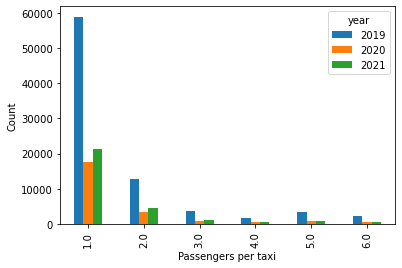

In [23]:
passengers_taxi(df, 'Passengers per taxi', 'Count')

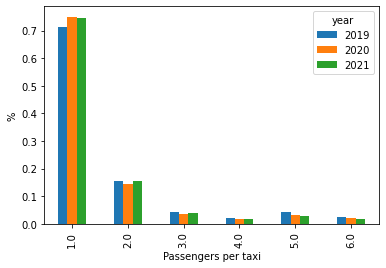

In [24]:
passengers_taxi(df, 'Passengers per taxi', '%', norm = True)

**Question: What impact have you seen on the data? Do you think covid had a lot of impact?**

> Yes. From the analysis of the percentage, it is possible to see an increase in the proportion of the number of trips with only 1 person per taxi. Social distancing due to covid may be the main factor that led people to prefer to ride a taxi alone.

___

## 03. Number of trips

So far, you have seen the number of trips there have been in the years studied.

Let's study what changes can be seen if you aggregate the data by hours, days of the week, week of the year, and months.


These visualizations have to be done for the *pick-up* and *drop-off* columns. 

Furthermore, the information has to be split by year and represented with dashed lines, and marked with a round or cross wherever the value is.

In [25]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,month_pickup
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,1
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,1
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,1
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,1
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,1


In [26]:
year = 2019
col = "pickup_month"
df["pickup_month"] = df['tpep_pickup_datetime'].dt.month
df["pickup_week"] = df['tpep_pickup_datetime'].dt.isocalendar().week
df["pickup_hour"] = df['tpep_pickup_datetime'].dt.hour
df["pickup_day"] = df['tpep_pickup_datetime'].dt.dayofweek

df[df["year"]==year][["pickup_month"]].value_counts().reset_index()

,pickup_month,0
0,3,7675
1,1,7547
2,5,7426
3,4,7293
4,10,7022
5,2,6877
6,6,6806
7,12,6715
8,11,6702
9,9,6402


In [27]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Function that visualizes the number of trips by different data aggregations
    """

    col = columns[0]
    for year in YEARS:

        counts = df[df["year"]==year][[col]].value_counts().reset_index().sort_values(by=col)
        plt.plot(counts[col], counts[0], linestyle='dashed', color='gray')
        plt.scatter(counts[col], counts[0], label = year)
        
#         counts = df.loc[df.year == year, col].value_counts().sort_index()
#         plt.plot([counts.index], [counts.values], linestyle='dashed', color='gray')
#         plt.scatter([counts.index], [counts.values], label = year)
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    

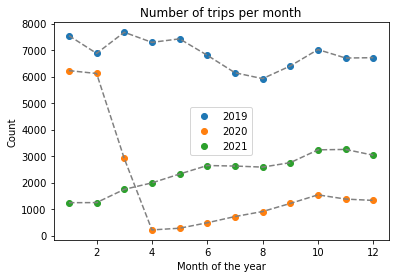

In [28]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title = 'Number of trips per month', xlabel = 'Month of the year', ylabel = 'Count')

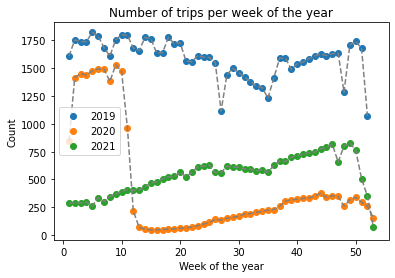

In [29]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title = 'Number of trips per week of the year', xlabel = 'Week of the year', ylabel = 'Count')

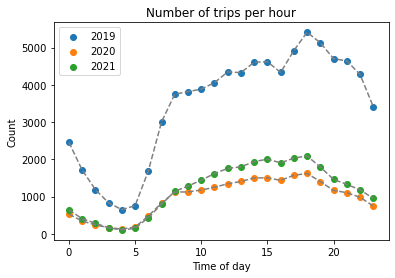

In [30]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Number of trips per hour', xlabel = 'Time of day', ylabel = 'Count')

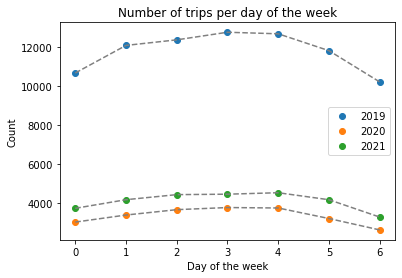

In [31]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Number of trips per day of the week', xlabel = 'Day of the week', ylabel = 'Count')

**Question: What behaviors do you see in each case? What do you think is the reason?**

> Analysis continues to show a very large reduction in the number of taxi trips in 2020 and 2021.
<br>In graphs "Number of trips per month" and "Number of trips per week of the year", we see a sudden reduction in the number of trips in March and April 2020, when the pandemic and lockdown began. Then we see the number of trips slowly increasing again. In 2021, we can see the continuation of this gradual growth in the number of trips.
<br>In graph "Number of trips per day of the week", we see a similar behavior over the 3 years analyzed (despite the large difference in quantity), with Wednesday and Thursday being the days with the most taxi trips.

___

## 04. Distance/duration and speed relationship

In the data, there is the distance traveled by taxis on each trip. Furthermore, you can extract the duration of the trips using: *tpep_dropoff_datetime* and *tpep_pickup_datetime*.

Now, you will find out how covid affected the distances and durations of journeys along with the speed of taxis.

Do you think the traffic density changed?

### Histograms

Visualize the **histograms** of distance and duration per year.

You can use *plt.hist()* or *plt.bar()* function.

In [32]:
df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds()/3600
df[["trip_duration", "tpep_dropoff_datetime", "tpep_pickup_datetime"]]

,trip_duration,tpep_dropoff_datetime,tpep_pickup_datetime
0,0.111111,2019-01-01 00:53:20,2019-01-01 00:46:40
1000,0.135278,2019-01-01 01:01:16,2019-01-01 00:53:09
2000,0.489444,2019-01-01 01:19:44,2019-01-01 00:50:22
3000,0.140833,2019-01-01 01:03:13,2019-01-01 00:54:46
4000,0.050000,2019-01-01 00:12:29,2019-01-01 00:09:29
...,...,...,...
3107000,23.346389,2022-01-01 21:23:40,2021-12-31 22:02:53
3108000,0.161111,2021-12-31 22:55:16,2021-12-31 22:45:36
3109000,0.161389,2021-12-31 23:05:10,2021-12-31 22:55:29
3110000,0.057778,2021-12-31 23:29:32,2021-12-31 23:26:04


In [33]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim, ylim):
    """
    Function that creates a histogram from the information contained in the column *column* of the dataframe *df*
    """
    
    fig, axs = plt.subplots(3, 1, figsize = (6, 6))
    
    axs[0].hist(x=df[df["year"]==2019][column], bins=10)
    axs[0].set_title(title)
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel + " 2019")
    
    axs[1].hist(x=df[df["year"]==2020][column], bins=10)
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel + " 2020")
    
    axs[2].hist(x=df[df["year"]==2021][column], bins=10)
    axs[2].set_xlim(xlim)
    axs[2].set_ylim(ylim)
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylabel(ylabel + " 2021")    

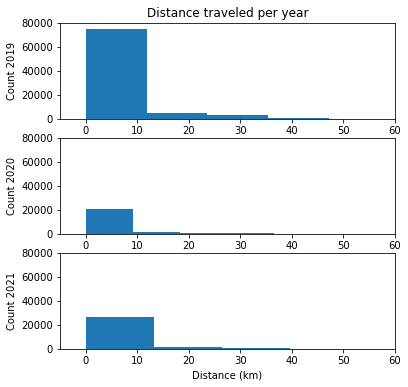

In [34]:
visualize_histograms(df, 'trip_distance', title = 'Distance traveled per year', 
                     xlabel = 'Distance (km)', ylabel = 'Count', xlim = (-5, 60), ylim = (0, 80000))

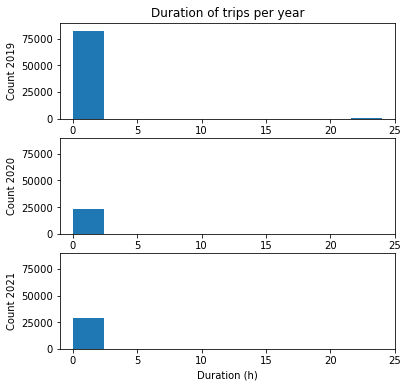

In [35]:
visualize_histograms(df, 'trip_duration', title = 'Duration of trips per year', 
                     xlabel = 'Duration (h)', ylabel = 'Count', xlim = (-1, 25), ylim = (0, 90000))

**QUESTIONS:**

* How do you think covid affected travel distances and durations?

* And the speed of taxis?

> In 2020, there was a predominance of shorter trips (less than 10km), compared to other years. This behavior may have been caused due to people taking only necessary trips, usually for work or everyday needs.

___

### Scatter plot and correlation

Create scatter plots to illustrate the relationship between trip duration and distance.

It is possible that the data contain samples outside the distribution (outliers). In this case, skip this samples and display the figure again.

To see if any correlation exists, it is interesting to use the *sns.regplot()* function.

In [36]:
import seaborn as sns

In [37]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Function that displays a scatter plot given the name of the columns that contains the information
    """
    df2=df
    if remove_outliers:
        df2=df2[(df2[x_value]<=df2[x_value].quantile(0.99)) & (df2[x_value]>=df2[x_value].quantile(0.01))]
        df2=df2[(df2[y_value]<=df2[y_value].quantile(0.99)) & (df2[y_value]>=df2[y_value].quantile(0.01))]
    
    fig = sns.regplot(data = df2, x=x_value, y=y_value, scatter_kws={"alpha":0.4}, line_kws={"color": "black"})
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show(fig)
    

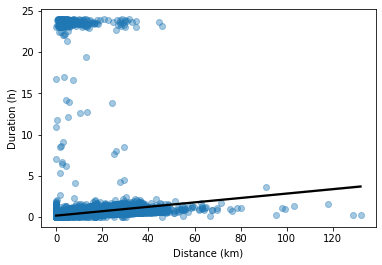

In [38]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distance (km)', 'Duration (h)')

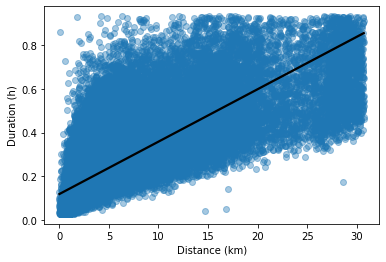

In [39]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distance (km)', 'Duration (h)', True)

In [40]:
df[['trip_distance', 'trip_duration']].corr()

,trip_distance,trip_duration
trip_distance,1.000000,0.146702
trip_duration,0.146702,1.000000


**Question: Can you see any relationship? Can you calculate the correlation between the data to get more information?**

> The greater the distance, the longer the time spent on each trip. Removing outliers allows us to better visualize this correlation.

In [41]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,month_pickup,pickup_month,pickup_week,pickup_hour,pickup_day,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,1,1,1,0,1,0.111111
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,1,1,1,0,1,0.135278
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,1,1,1,0,1,0.489444
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,1,1,1,0,1,0.140833
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,1,1,1,0,1,0.050000


In [42]:
df[df["year"]==2019].groupby("month_pickup")[["trip_distance"]].mean().reset_index().sort_values(by="month_pickup")

,month_pickup,trip_distance
0,1,4.460792
1,2,4.654569
2,3,4.754483
3,4,4.800886
4,5,4.832246
5,6,4.853706
6,7,5.000519
7,8,5.001545
8,9,4.843384
9,10,4.706014


As you did in section 3, visualize the time and distance data for the weeks and months of the year.

In [43]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Function that show the distance / duration of trips in the time determined
    """

    col = columns[0]
    for year in YEARS:

        df2 = df[df["year"]==year].groupby(col)[[column_data]].mean().reset_index().sort_values(by=col)
        plt.plot(df2[col], df2[column_data], linestyle='dashed', color='gray')
        plt.scatter(df2[col], df2[column_data], label = year)

    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    

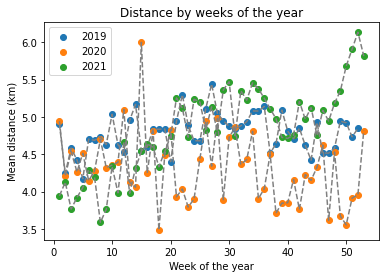

In [44]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Week of the year', ylabel = 'Mean distance (km)', title = 'Distance by weeks of the year')

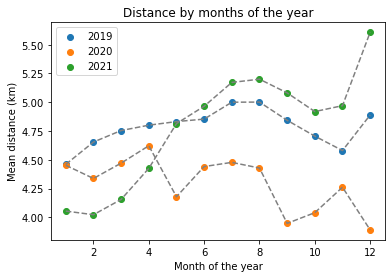

In [45]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Month of the year', ylabel = 'Mean distance (km)', title = 'Distance by months of the year')

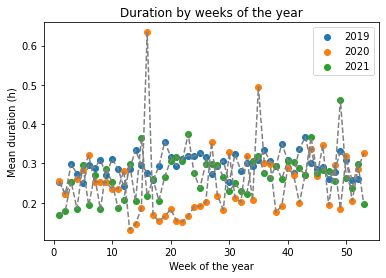

In [46]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Week of the year', ylabel = 'Mean duration (h)', title = 'Duration by weeks of the year')

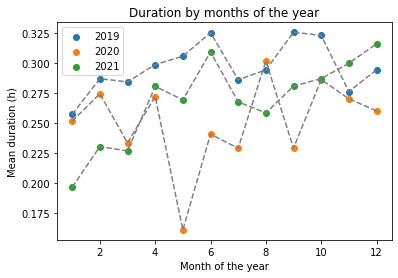

In [47]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Month of the year', ylabel = 'Mean duration (h)', title = 'Duration by months of the year')

**Question: Is there any strange behavior apart from covid? What can it be caused by?**

> In the week charts, it is possible to see that in the first weeks of April 2020 there was an increase of the distances traveled and the duration of trips. This could coincide with people traveling to quarantine outside of NY.
At the end of August, there is also an increase in the time and distance traveled by taxi, which may be related to the beginning of the school year.
<br>On Thanksgiving holiday (November), there is an increase in long trips in 2019 and 2021, and a reduction in 2020. This may be related to the lockdowns made in the first year of the pandemic.
<br>In the monthly charts, in 2020 it is possible to notice a reduction in distance and duration of trips at the beginning of the pandemic (April). In 2019 and 2021, there is an increase in the distances covered in July, August and December.

___

So far, you have shown the data by aggregating different information.

Now, you have to visualize the data like images. For that, you will use the *plt.imshow()* function which displays images and arrays.

Implement a function that displays heatmaps by year (each function display 3 heatmaps, one per year):

- a heatmap showing what time of day are the longest trips during the year.
- a heatmap showing what time of day are the longest trips during the week.

In [48]:
df['pickup_dayofyear'] = df.tpep_pickup_datetime.dt.dayofyear

In [49]:
year = 2019
group = ['pickup_hour', 'pickup_dayofyear']

df_y = df[df.year == 2019]
df_y.groupby(group).mean()['trip_duration'].unstack().fillna(0) #fillna substitui nan por 0


pickup_dayofyear,1,2,3,4,5,6,7,8,9,10,...,356,357,358,359,360,361,362,363,364,365
pickup_hour,,,,,,,,,,,,,,,,,,,,,
0,1.858591,0.186944,0.256296,0.217667,0.176187,0.258939,0.305370,0.313981,0.406528,0.149074,...,0.165595,0.308889,0.327153,0.278750,0.223333,0.112407,0.168009,0.199383,0.254306,0.113944
1,0.231111,0.129167,0.147361,0.193981,0.119514,0.154290,0.367778,0.112778,0.158889,0.354722,...,0.208492,0.094444,0.231528,0.326296,0.134722,0.102361,0.243833,0.187222,0.095625,0.261296
2,0.256528,0.066944,0.141667,0.279444,0.127817,0.134383,0.146389,0.157222,0.133750,0.120139,...,0.063722,0.014167,0.108611,0.422917,0.060833,0.175694,0.123958,0.119514,0.000000,0.200972
3,0.304116,0.051944,0.049167,0.144167,0.144653,0.174722,0.105000,0.236667,0.423611,0.143056,...,0.170556,0.000000,0.251667,0.270833,0.000000,0.415278,0.057870,0.221528,0.215556,0.544444
4,0.188810,0.245278,0.078889,0.170833,0.094861,0.034861,0.169444,0.042500,0.295000,0.422778,...,0.221389,0.117778,0.376111,0.160833,0.111944,0.054167,0.157639,0.087500,0.053333,0.116667
5,0.241019,0.217639,0.136944,0.080694,0.279583,0.140556,0.411528,0.185833,0.198889,0.105000,...,0.115278,0.230000,0.068889,0.222778,0.000000,0.063889,0.090278,0.117500,0.345833,0.199444
6,0.321806,0.175952,0.289556,0.093657,0.273472,0.159861,0.219762,0.105417,0.151071,0.103492,...,0.086667,0.165185,0.182500,0.055833,0.085556,0.096944,0.129861,0.112222,0.221389,0.341250
7,0.149167,0.096111,0.191852,0.273278,0.290764,0.171667,0.172894,0.148675,0.196709,0.146645,...,0.162778,0.205444,0.144111,0.104444,0.269907,0.154630,0.160833,0.452500,0.078500,0.240500
8,0.121667,0.206458,0.337972,0.212616,0.169815,0.105278,0.219316,0.162465,0.211171,0.165851,...,0.223264,0.179286,0.089667,0.165972,0.149333,0.149306,0.177870,0.221111,0.278009,0.263264


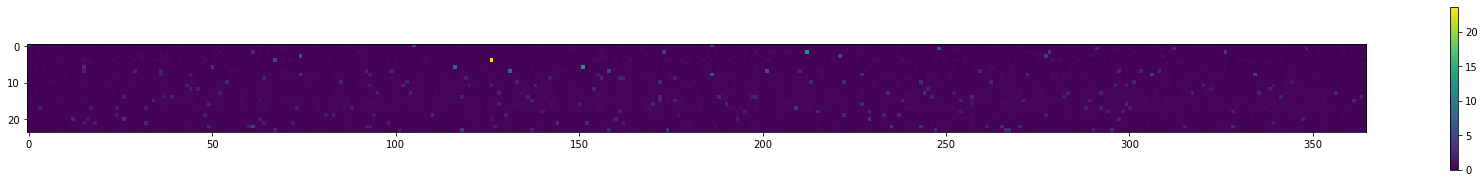

In [50]:
year = 2019
group = ['pickup_hour', 'pickup_dayofyear']

df_y = df[df.year == 2019]
values = df_y.groupby(group).mean()['trip_duration'].unstack().fillna(0).values

plt.figure(figsize = (30, 3))
plt.imshow(values)

plt.colorbar()

In [51]:
values.shape

(24, 365)

In [52]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Function that aggregates data appropriately to display a heatmap
    """
    fig, axs = plt.subplots(3, 1, figsize = (30, 10))
    
    values = df[df.year == 2019].groupby(group).mean()[column_data].unstack().fillna(0).values
    im0 = axs[0].imshow(values)
    plt.colorbar(im0, ax=axs[0])
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[0].set_ylabel(ylabel + " 2019")
    
    values = df[df.year == 2020].groupby(group).mean()[column_data].unstack().fillna(0).values
    im1 = axs[1].imshow(values)
    plt.colorbar(im1, ax=axs[1])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)
    axs[1].set_ylabel(ylabel + " 2020")
    
    values = df[df.year == 2021].groupby(group).mean()[column_data].unstack().fillna(0).values
    im2 = axs[2].imshow(values)
    plt.colorbar(im2, ax=axs[2])
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylabel(ylabel)
    axs[2].set_ylabel(ylabel + " 2021")  
    
    if columns:
        axs[0].set_xticks(np.arange(values.shape[1]))
        axs[1].set_xticks(np.arange(values.shape[1]))
        axs[2].set_xticks(np.arange(values.shape[1]))
        
        axs[0].set_xticklabels(columns)
        axs[1].set_xticklabels(columns)
        axs[2].set_xticklabels(columns)
        
        plt.setp(axs[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.setp(axs[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.setp(axs[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
    fig.tight_layout()
    
#     plt.colorbar()

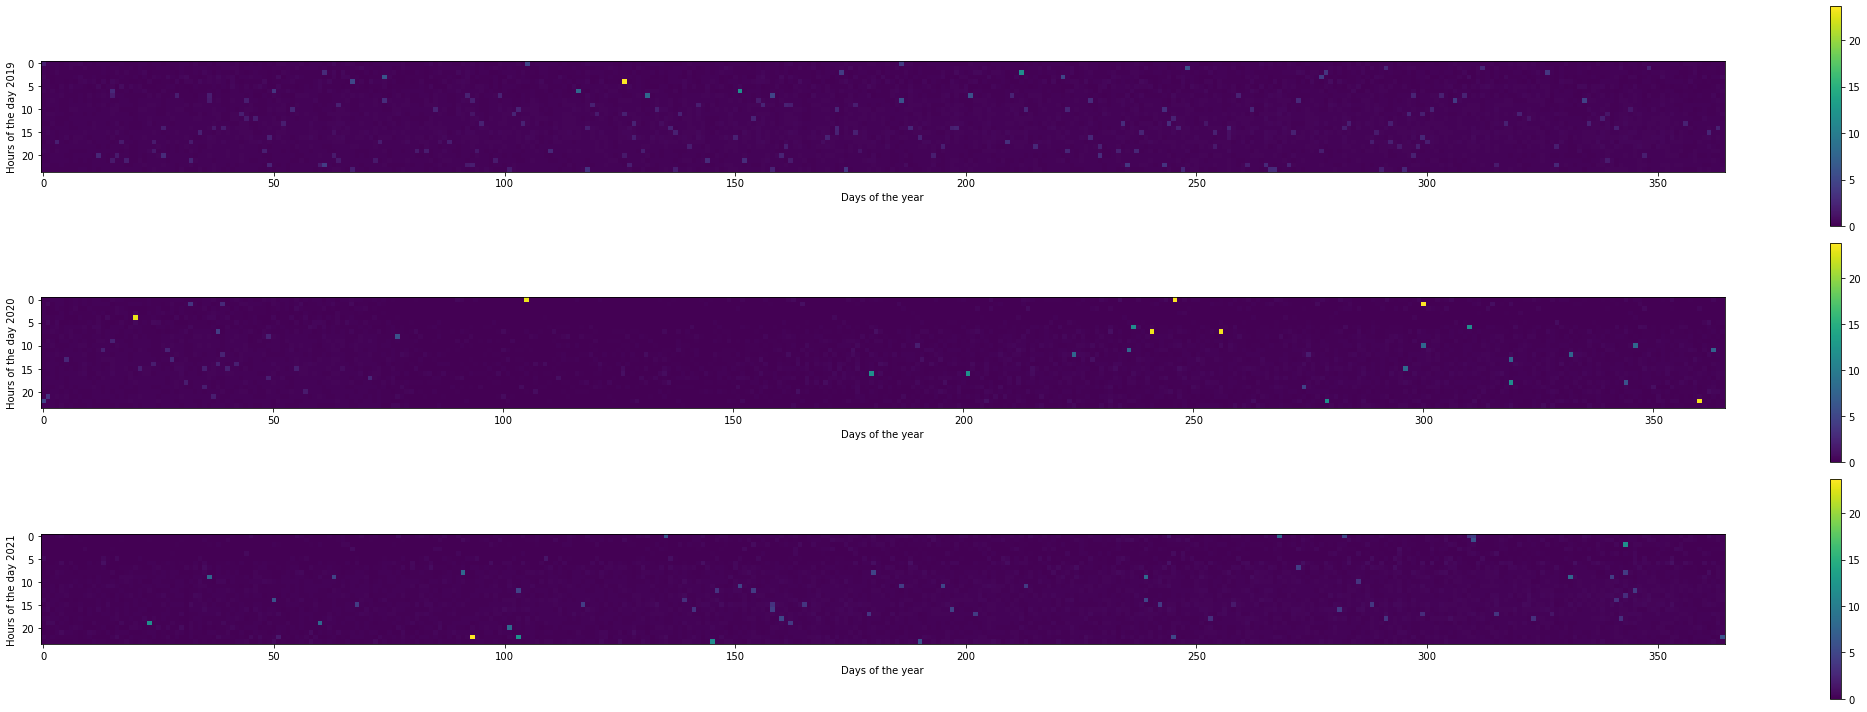

In [53]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Days of the year', 'Hours of the day')

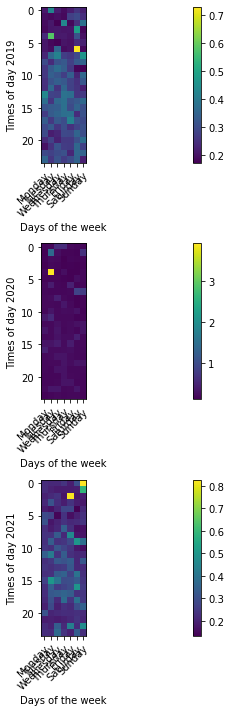

In [54]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Days of the week', 'Times of day', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeat the previous heatmaps visualizing the distance.

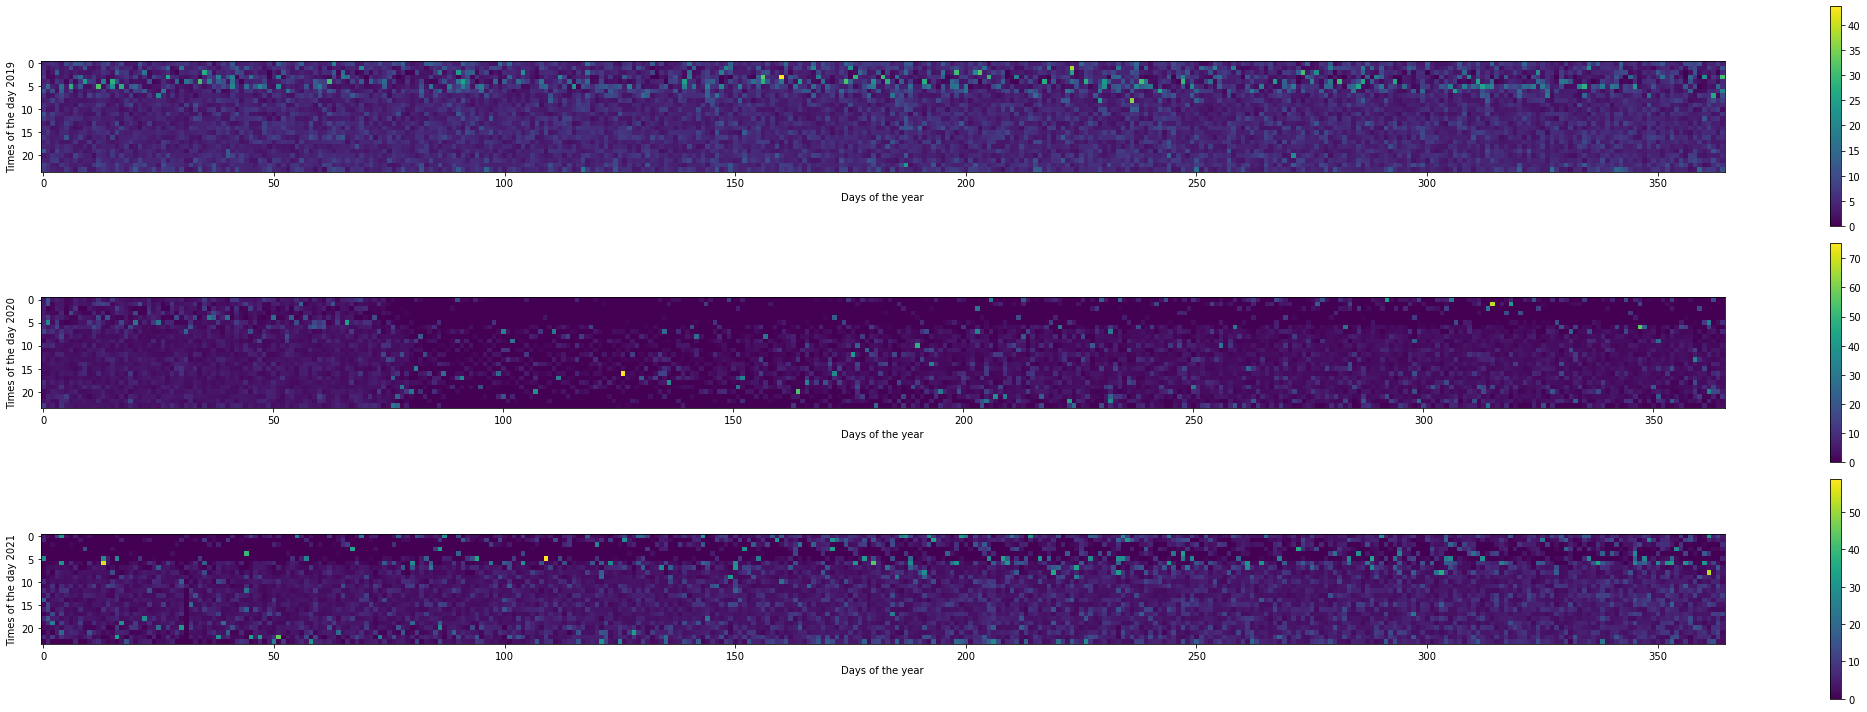

In [55]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Days of the year', 'Times of the day')

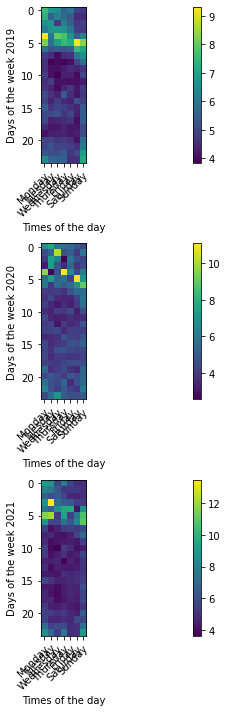

In [56]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Times of the day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Finally, view the average speed at different times of the day during the week.

In [57]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,month_pickup,pickup_month,pickup_week,pickup_hour,pickup_day,trip_duration,pickup_dayofyear
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,1,1,1,0,1,0.111111,1
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,1,1,1,0,1,0.135278,1
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,1,1,1,0,1,0.489444,1
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,1,1,1,0,1,0.140833,1
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,1,1,1,0,1,0.050000,1


In [58]:
df["trip_speed"] = df["trip_distance"] / df["trip_duration"]

In [59]:
def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Function that aggregates data appropriately to display a speed heatmap
    """
    heatmap(df=df, group=group, column_data="trip_speed", xlabel=xlabel, ylabel=ylabel, columns = columns)
        
    

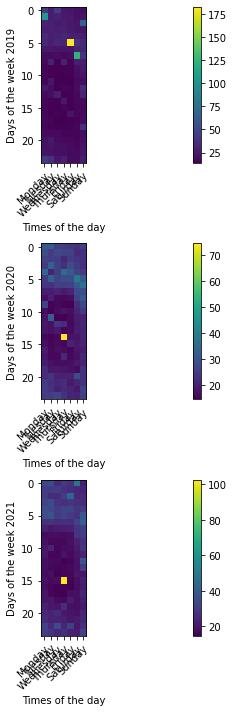

In [60]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Times of the day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Question: Which conclusions do you obtain from the heatmaps?**
    
> I'm not really sure about the conclusions from the heatmaps.
<br>In the annual maps, it is possible to see a concentration of taxi trips in the early morning throughout the year.
<br> In the weekly maps, it is possible that some outliers are compromising the visualization (yellow dots).

## 05. Visualize the locations of the trips

In [61]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,month_pickup,pickup_month,pickup_week,pickup_hour,pickup_day,trip_duration,pickup_dayofyear,trip_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,1,1,1,0,1,0.111111,1,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,1,1,1,0,1,0.135278,1,22.590554
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,1,1,1,0,1,0.489444,1,25.171396
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,1,1,1,0,1,0.140833,1,15.905325
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,1,1,1,0,1,0.050000,1,21.440000


The data only has the ID of a location, so you need to add the latitude and longitude.

This information is saved in *data/geodata/taxi_zones.shp*.

The next cells can be understood as a black box.

In [62]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [63]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [64]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head(10)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,-74.072566,40.599043
6,7,0.107417,0.000390,Astoria,7,Queens,-73.920307,40.761083
7,8,0.027591,0.000027,Astoria Park,8,Queens,-73.923122,40.778625
8,9,0.099784,0.000338,Auburndale,9,Queens,-73.786517,40.754343
9,10,0.099839,0.000436,Baisley Park,10,Queens,-73.788986,40.678256


C:\Users\danir\anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


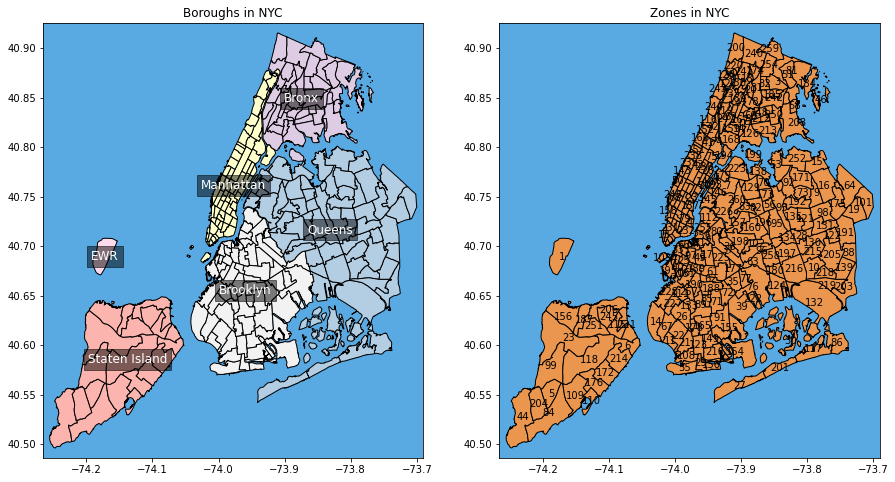

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Now you have two dataframes that you need to join. Use the *pd.merge* function to add the longitude and latitude to the *df* dataframe:

In [66]:
merge = pd.merge(left=df, right=df_loc[["LocationID","longitude","latitude"]], left_on = 'PULocationID', right_on = 'LocationID')
merge = merge.rename(columns={"longitude":"PUlongitude", "latitude":"PUlatitude"})
merge = merge.drop("LocationID",axis=1)

merge = pd.merge(left=merge, right=df_loc[["LocationID","longitude","latitude"]], left_on = 'DOLocationID', right_on = 'LocationID')
merge = merge.rename(columns={"longitude":"DOlongitude", "latitude":"DOlatitude"})
merge = merge.drop("LocationID",axis=1)

In [67]:
merge.shape

(133061, 22)

In [68]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'total_amount', 'year', 'month_pickup', 'pickup_month',
       'pickup_week', 'pickup_hour', 'pickup_day', 'trip_duration',
       'pickup_dayofyear', 'trip_speed'],
      dtype='object')

In [69]:
df_loc.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'longitude', 'latitude'],
      dtype='object')

In [70]:
merge.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'total_amount', 'year', 'month_pickup', 'pickup_month',
       'pickup_week', 'pickup_hour', 'pickup_day', 'trip_duration',
       'pickup_dayofyear', 'trip_speed', 'PUlongitude', 'PUlatitude',
       'DOlongitude', 'DOlatitude'],
      dtype='object')

In [71]:
merge.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_week,pickup_hour,pickup_day,trip_duration,pickup_dayofyear,trip_speed,PUlongitude,PUlatitude,DOlongitude,DOlatitude
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,...,1,0,1,0.111111,1,21.600000,-73.968222,40.797859,-73.978732,40.784025
1,2019-01-03 09:52:47,2019-01-03 09:57:36,1.0,1.408,151,239,1,5.5,8.55,2019,...,1,9,3,0.080278,3,17.539100,-73.968222,40.797859,-73.978732,40.784025
2,2019-01-04 13:45:10,2019-01-04 13:51:19,1.0,1.760,151,239,1,6.0,8.15,2019,...,1,13,4,0.102500,4,17.170732,-73.968222,40.797859,-73.978732,40.784025
3,2019-01-04 16:49:03,2019-01-04 16:52:53,2.0,1.440,151,239,2,5.0,6.80,2019,...,1,16,4,0.063889,4,22.539130,-73.968222,40.797859,-73.978732,40.784025
4,2019-01-11 14:00:40,2019-01-11 14:08:25,1.0,1.664,151,239,1,7.0,9.36,2019,...,2,14,4,0.129167,11,12.882581,-73.968222,40.797859,-73.978732,40.784025
5,2019-01-11 18:11:15,2019-01-11 18:15:14,1.0,1.600,151,239,2,5.0,6.80,2019,...,2,18,4,0.066389,11,24.100418,-73.968222,40.797859,-73.978732,40.784025
6,2019-01-14 16:46:28,2019-01-14 16:52:53,2.0,2.320,151,239,1,6.5,9.79,2019,...,3,16,0,0.106944,14,21.693506,-73.968222,40.797859,-73.978732,40.784025
7,2019-01-15 07:23:35,2019-01-15 07:28:32,2.0,1.936,151,239,1,6.0,8.16,2019,...,3,7,1,0.082500,15,23.466667,-73.968222,40.797859,-73.978732,40.784025
8,2019-01-17 16:48:25,2019-01-17 16:56:51,4.0,2.320,151,239,1,8.0,11.76,2019,...,3,16,3,0.140556,17,16.505929,-73.968222,40.797859,-73.978732,40.784025
9,2019-01-21 15:13:48,2019-01-21 15:18:49,1.0,1.920,151,239,1,6.0,7.80,2019,...,4,15,0,0.083611,21,22.963455,-73.968222,40.797859,-73.978732,40.784025


## 06. Which are the areas/zones with more pick-up and drop-off?

In this section, you have to visualize the areas where taxis are most used.

The first step is to sort and save in a variable the most common places in the pick-up and drop-off.

The variables *top_pu* and *top_do* contains a dataframe with columns: 'year', 'PULocationID', and 'count'.

In [72]:
# Pick-up:

top_pu = merge[["year","PULocationID"]].value_counts().reset_index()
top_pu.columns = ['year', 'PULocationID', 'count']

# Drop-off:

top_do = merge[["year", "DOLocationID"]].value_counts().reset_index()
top_do.columns = ['year', 'DOLocationID', 'count']

In [73]:
top_pu

,year,PULocationID,count
0,2019,237,3514
1,2019,161,3417
2,2019,236,3221
3,2019,162,3003
4,2019,186,3000
...,...,...,...
536,2019,251,1
537,2021,95,1
538,2021,94,1
539,2020,185,1


In [74]:
top_pu[top_pu["year"]==2019].sort_values(by="count", ascending=False)["PULocationID"].head()

0    237
1    161
2    236
3    162
4    186
Name: PULocationID, dtype: int64

Print the 5 most frequent zones per year and in each case (pick-up and drop-off).

In [75]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    
    """
    Function that print the most common zones by year
    """
    for year in YEARS:
        print(str(year) + ":")
        df2 = df[df["year"]==year].sort_values(by="count", ascending=False).head(n_top)
        df2 = pd.merge(left=df2, right=df_loc[["zone","LocationID"]], left_on=column, right_on="LocationID")
        print(df2["zone"])
        
            
    

In [76]:
show_top_n(top_pu, 'PULocationID', df_loc)

2019:
0           Upper East Side South
1                  Midtown Center
2           Upper East Side North
3                    Midtown East
4    Penn Station/Madison Sq West
Name: zone, dtype: object
2020:
0           Upper East Side South
1           Upper East Side North
2                  Midtown Center
3                    Midtown East
4    Penn Station/Madison Sq West
Name: zone, dtype: object
2021:
0           Upper East Side South
1           Upper East Side North
2                  Midtown Center
3                     JFK Airport
4    Penn Station/Madison Sq West
Name: zone, dtype: object


In [77]:
show_top_n(top_do, 'DOLocationID', df_loc)

2019:
0    Upper East Side North
1           Midtown Center
2    Upper East Side South
3              Murray Hill
4             Midtown East
Name: zone, dtype: object
2020:
0    Upper East Side North
1    Upper East Side South
2           Midtown Center
3          Lenox Hill West
4              Murray Hill
Name: zone, dtype: object
2021:
0    Upper East Side North
1    Upper East Side South
2           Midtown Center
3              Murray Hill
4    Upper West Side South
Name: zone, dtype: object


**Let's see with a heat map which are the most common zones**

C:\Users\danir\anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


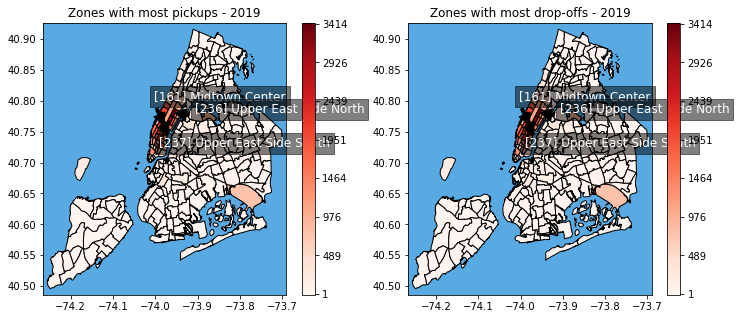

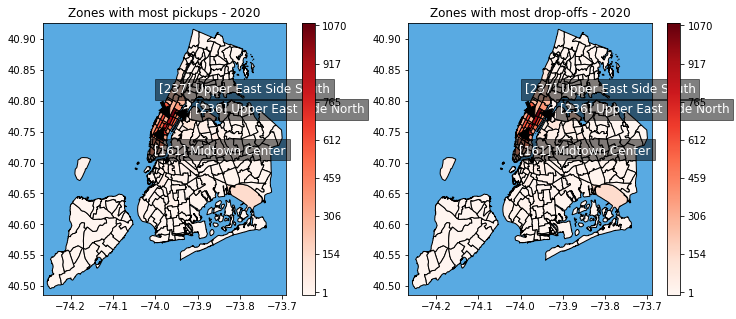

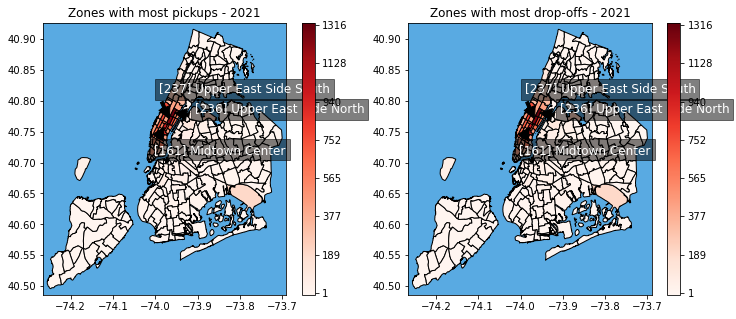

In [78]:
for year in YEARS:
    
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'count']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Question: Why do you think the Manhattan area has more trips?**

> Manhattan is the area of the city with the highest concentration of people who live and/or work there.

## 07. Hospitals

How has the travel destination changed? Are more people going to hospitals?

In the next cell, there is a DataFrame with the most important hospitals in New York and their locations.

(calu=cu

In [79]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head(10)

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077
5,"Envy Smile Dental Spa, Brooklyn, NYC, NY, USA",40.607059,-73.960144
6,"VIVA EVE, Forest Hills, NYC, NY, USA",40.734291,-73.849434
7,"Forest Hills Medical Services, Queens, NYC, NY...",40.734310,-73.849510
8,"Professional Gynecological Services, Brooklyn,...",40.689747,-73.982346
9,"Manhattan Womens Health & Wellness, New York, ...",40.741997,-73.986107


Use the latitude and longitude of each hospital and the latitude and longitude of the zone (information in *merge* dataframe) to see the distribution of the hospitals "on the map".

To do this, use a scatter plot. It will be better understood if the points are transparent (parameter *alpha*).

Also, remember how the longitude and latitude data have to be plotted in the figure.

Then repeat the same scatter plot but separated by years.

In [80]:
merge.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'total_amount', 'year', 'month_pickup', 'pickup_month',
       'pickup_week', 'pickup_hour', 'pickup_day', 'trip_duration',
       'pickup_dayofyear', 'trip_speed', 'PUlongitude', 'PUlatitude',
       'DOlongitude', 'DOlatitude'],
      dtype='object')

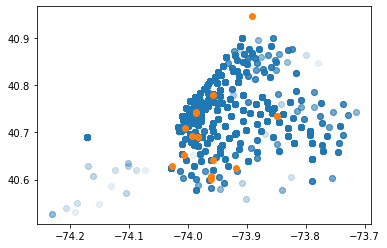

In [81]:
plt.scatter(merge.DOlongitude, merge.DOlatitude, alpha = 0.1)
plt.scatter(hospitals.Longitude, hospitals.Latitude)

In [82]:
def scatter_locations(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations"""
    fig = plt.figure(figsize = (7,7))
    ax = fig.add_subplot()
    ax.scatter(merge.DOlongitude, merge.DOlatitude, alpha = 0.1)
    ax.scatter(hospitals.Longitude, hospitals.Latitude, label = "Hospital")
    ax.legend()
    

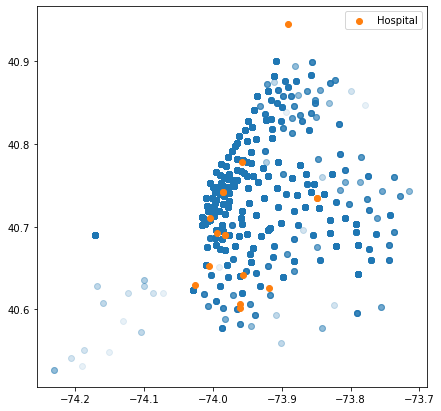

In [83]:
scatter_locations(merge, hospitals)

In [84]:
def scatter_locations_per_year(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations per year"""
                  
 
    fig, axs = plt.subplots(3, 1, figsize = (7, 21))
    
    axs[0].scatter(merge[merge["year"]==2019].DOlongitude, merge[merge["year"]==2019].DOlatitude, alpha = 0.1)
    axs[0].scatter(hospitals.Longitude, hospitals.Latitude, label = "Hospital")
    axs[0].legend(title="2019")
    
    axs[1].scatter(merge[merge["year"]==2020].DOlongitude, merge[merge["year"]==2020].DOlatitude, alpha = 0.1)
    axs[1].scatter(hospitals.Longitude, hospitals.Latitude, label = "Hospital")
    axs[1].legend(title="2020")

    axs[2].scatter(merge[merge["year"]==2021].DOlongitude, merge[merge["year"]==2021].DOlatitude, alpha = 0.1)
    axs[2].scatter(hospitals.Longitude, hospitals.Latitude, label = "Hospital")
    axs[2].legend(title="2021")

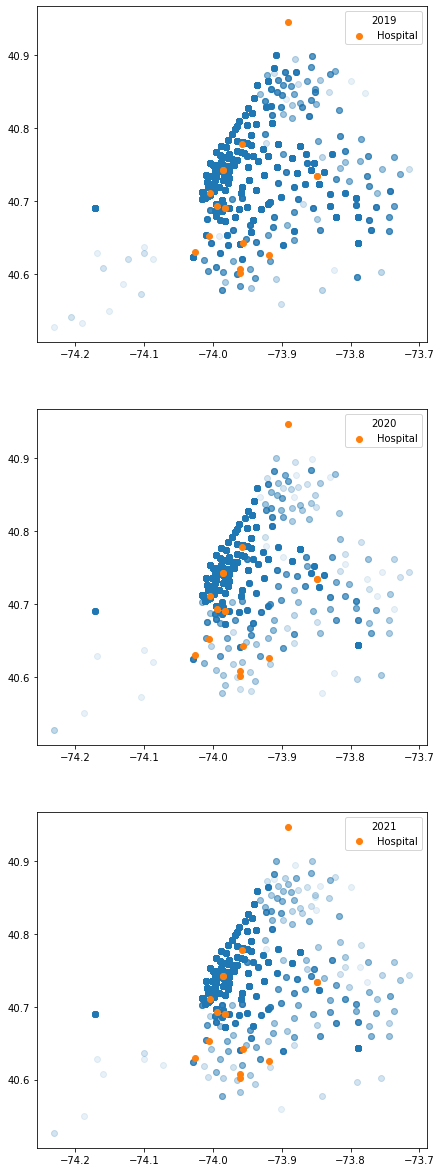

In [85]:
scatter_locations_per_year(merge, hospitals)

**Question: Do you see any behavior?**

> It is possible to see that the area of some hospitals remained with a high number of trips in 2020 and 2021, while in the other areas there was a reduction in the concentration of trips.

To find out how trips to hospitals have changed, you need to detect in which zone is each hospital.

To do it, you need to calculate the distances between the hospitals and the zones. 

Do not calculate the distance point-to-point, but matrix-wise.

In [86]:
from scipy.spatial import distance_matrix

In [87]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values

dist = distance_matrix(hospitals_loc, loc)

In [88]:
dist.shape

(16, 271)

In [89]:
hospitals_loc.shape

(16, 2)

In [90]:
loc.shape

(271, 2)

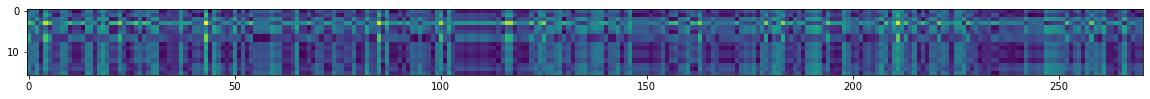

In [91]:
# Distances as an image
plt.figure(figsize=(20, 5))
plt.imshow(dist)

Find a way to locate the nearest sector based on distances.

In [92]:
hospitals_locations = dist.argmin(1)
hospitals['LocationID'] = hospitals_locations

In [93]:
hospitals.head(20)

,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,216
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,243
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,130
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,207
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,13
5,"Envy Smile Dental Spa, Brooklyn, NYC, NY, USA",40.607059,-73.960144,130
6,"VIVA EVE, Forest Hills, NYC, NY, USA",40.734291,-73.849434,55
7,"Forest Hills Medical Services, Queens, NYC, NY...",40.734310,-73.849510,55
8,"Professional Gynecological Services, Brooklyn,...",40.689747,-73.982346,24
9,"Manhattan Womens Health & Wellness, New York, ...",40.741997,-73.986107,241


Now that you know the zone of each hospital, visualize how many trips are related to them.

You will assume that all trips in the zone go to the hospital.

Make a single figure with two bar plots showing the number of trips for each year and the % of total trips.

In [94]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,month_pickup,pickup_month,pickup_week,pickup_hour,pickup_day,trip_duration,pickup_dayofyear,trip_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,1,1,1,0,1,0.111111,1,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,1,1,1,0,1,0.135278,1,22.590554
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,1,1,1,0,1,0.489444,1,25.171396
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,1,1,1,0,1,0.140833,1,15.905325
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,1,1,1,0,1,0.050000,1,21.440000


In [95]:
hospitals_locations

array([216, 243, 130, 207,  13, 130,  55,  55,  24, 241,  24,  32, 114,
        90, 162, 235], dtype=int64)

In [96]:
def trips_hospitals(df, hospitals_locations):
    """
    Function that displays a single figure with two bar plots showing the number of trips for each year and the % of total trips.
    """
    df_year = df["year"].value_counts().reset_index()
    df_year.columns = ["year", "total trips"]

    df2 = df[df["DOLocationID"].isin(hospitals_locations)]

    df_total = df2["year"].value_counts().reset_index()
    df_total.columns = ["year", "trips"]
    df_total = pd.merge(left=df_total, right=df_year, left_on = "year", right_on = "year")

    df_total["perc_trips"] = df_total["trips"] / df_total["total trips"]
    df_total = df_total.sort_values(by = "year")
    
    fig, axs = plt.subplots(2, 1, figsize = (6, 6))
    
    
    axs[0].bar(x=df_total["year"], height=df_total["trips"])

    axs[1].bar(x=df_total["year"], height=df_total["perc_trips"])
    
    
    axs[0].set_xticks([2019,2020,2021])
    axs[1].set_xticks([2019,2020,2021])

        
    axs[0].set_xticklabels(df_total["year"])
    axs[1].set_xticklabels(df_total["year"])



    

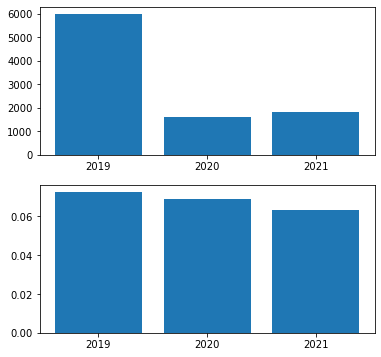

In [97]:
trips_hospitals(df, hospitals_locations)

## 08. Curiosity killed the cat

In the **first part** you must view and comment on the examples you have removed, such as very long distances, very short distances...

In the **second part** you are free to choose and make visualizations that bring you extra information that has not been seen before.

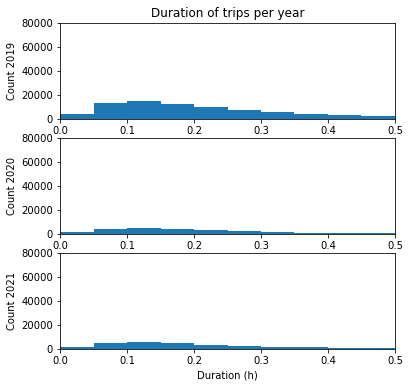

In [98]:
visualize_histograms(df[df["trip_duration"]<=0.5], 'trip_duration', title = 'Duration of trips per year', 
                     xlabel = 'Duration (h)', ylabel = 'Count', xlim = (0, 0.5), ylim = (0, 80000))

## 09. Report

Based on the data exploration you have done throughout this notebook, make a short report summarizing and justifying all the changes that have arisen due to covid.

> Covid19 has clearly affected the behavior of taxis in NY and probably harmed people who work as taxi drivers.
<br> The number of trips has drastically reduced, especially in 2020, as well as the duration and distance traveled, which has the consequence of reducing taxi drivers' billing.
<br>In addition, through data analysis, it was possible to notice that people, probably due to fear of contamination, made more trips alone than in the previous year.